<a href="https://colab.research.google.com/github/rafaelnordavind/artigo-final/blob/main/02_Artigo_keras_sec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importando as bibliotecas utilizadas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import LSTM
from keras.models import load_model
import keras
import h5py
import requests
import os

<ipython-input-1-ff7fb938447d>:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [ ]:
# Baixando a base de dados do repositório do github
!mkdir dataset
!wget --no-check-certificate \
"https://raw.githubusercontent.com/rafaelnordavind/artigo-final/main/dataset/df_req_count.csv" \
-O "dataset/df_req_count.csv"

mkdir: cannot create directory ‘dataset’: File exists
--2023-06-26 07:01:27--  https://raw.githubusercontent.com/rafaelnordavind/artigo-final/main/dataset/df_req_count.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42452145 (40M) [text/plain]
Saving to: ‘dataset/df_req_count.csv’

dataset/df_req_coun 100%[===================>]  40.49M   157MB/s    in 0.3s    

2023-06-26 07:01:27 (157 MB/s) - ‘dataset/df_req_count.csv’ saved [42452145/42452145]



In [ ]:
# Lendo o arquivo com a contagem de requisições por segundo
data_df = pd.read_csv('dataset/df_req_count.csv', parse_dates=['timestamp'])
# Exibindo as primeiras linhas do dataset
data_df.head()

,Unnamed: 0,timestamp,num_requests
0,0,1995-08-28 00:00:34-04:00,1
1,1,1995-08-28 00:00:35-04:00,2
2,2,1995-08-28 00:00:36-04:00,2
3,3,1995-08-28 00:00:37-04:00,2
4,4,1995-08-28 00:00:38-04:00,4


In [ ]:
# Imprimindo a quantidade de linhas e colunas
data_df.shape

(1209511, 3)

In [ ]:
# Imprimindo o final do dataset para verificar até que data está contemplando
data_df.tail()

,Unnamed: 0,timestamp,num_requests
1209506,1209506,1995-09-10 23:59:00-04:00,2
1209507,1209507,1995-09-10 23:59:01-04:00,0
1209508,1209508,1995-09-10 23:59:02-04:00,0
1209509,1209509,1995-09-10 23:59:03-04:00,7
1209510,1209510,1995-09-10 23:59:04-04:00,2


In [ ]:
# Convertendo a coluna de tada pra um objeto datetime
data_df['timestamp'] = pd.to_datetime(data_df['timestamp'])

In [ ]:
# Exibindo as primeiras linhas do dataset
data_df.head()

,Unnamed: 0,timestamp,num_requests
0,0,1995-08-28 00:00:34-04:00,1
1,1,1995-08-28 00:00:35-04:00,2
2,2,1995-08-28 00:00:36-04:00,2
3,3,1995-08-28 00:00:37-04:00,2
4,4,1995-08-28 00:00:38-04:00,4


In [ ]:
# Normalizando o dataset para que os dados fique entre 0 e 1
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
dataset = min_max_scaler.fit_transform(data_df['num_requests'].values.reshape(-1, 1))

In [ ]:
# Exibindo os primeiros 10 dados já normalizados
dataset[0:10]

array([[0.02222222],
       [0.04444444],
       [0.04444444],
       [0.04444444],
       [0.08888889],
       [0.02222222],
       [0.02222222],
       [0.        ],
       [0.        ],
       [0.04444444]])

In [ ]:
# Dividindo o dataset entre treino e teste
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

846657 362854


In [ ]:
# Imprimindo a quantidade de linhas do dataset
print(len(data_df))

1209511


In [ ]:
# Convertendo um array de valores em uma matriz dataset
window_size = 1
def create_dataset(dataset, look_back=window_size):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
# Reshape entre X=t e Y=t+60
x_train, y_train = create_dataset(train, look_back=window_size)
x_test, y_test = create_dataset(test, look_back=window_size)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(846655, 1)
(846655,)
(362852, 1)
(362852,)


In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(846655, 1, 1)
(846655,)
(362852, 1, 1)
(362852,)


In [ ]:
# create and fit the LSTM network
from keras.layers import Bidirectional, Dropout
look_back = window_size
model = Sequential()
model.add(LSTM(64, input_shape=(1, look_back)))
model.add(Dropout(0.2))  # Adiciona camada de dropout com taxa de 0.2
model.add(Dense(1))
model.add(Activation("linear"))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=["mae"])
history = model.fit(
            x_train,
            y_train,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 10,
            validation_data=(x_test, y_test),
            verbose = 2,
            batch_size=10
            )

Epoch 1/20
100/100 - 2s - loss: 0.0031 - mae: 0.0423 - val_loss: 0.0042 - val_mae: 0.0474 - 2s/epoch - 23ms/step
Epoch 2/20
100/100 - 0s - loss: 0.0026 - mae: 0.0391 - val_loss: 0.0042 - val_mae: 0.0473 - 197ms/epoch - 2ms/step
Epoch 3/20
100/100 - 0s - loss: 0.0024 - mae: 0.0377 - val_loss: 0.0037 - val_mae: 0.0454 - 194ms/epoch - 2ms/step
Epoch 4/20
100/100 - 0s - loss: 0.0023 - mae: 0.0369 - val_loss: 0.0041 - val_mae: 0.0478 - 196ms/epoch - 2ms/step
Epoch 5/20
100/100 - 0s - loss: 0.0027 - mae: 0.0404 - val_loss: 0.0038 - val_mae: 0.0461 - 197ms/epoch - 2ms/step
Epoch 6/20
100/100 - 0s - loss: 0.0023 - mae: 0.0374 - val_loss: 0.0042 - val_mae: 0.0485 - 187ms/epoch - 2ms/step
Epoch 7/20
100/100 - 0s - loss: 0.0025 - mae: 0.0374 - val_loss: 0.0036 - val_mae: 0.0455 - 196ms/epoch - 2ms/step
Epoch 8/20
100/100 - 0s - loss: 0.0024 - mae: 0.0372 - val_loss: 0.0037 - val_mae: 0.0459 - 193ms/epoch - 2ms/step
Epoch 9/20
100/100 - 0s - loss: 0.0026 - mae: 0.0392 - val_loss: 0.0035 - val_mae:

In [ ]:
trainPredict = model.predict(x_train)
testPredict = model.predict(x_test)
# invert predictions
trainPredict = min_max_scaler.inverse_transform(trainPredict)
trainY = min_max_scaler.inverse_transform([y_train])
testPredict = min_max_scaler.inverse_transform(testPredict)
testY = min_max_scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

11340/11340 [==============================] - 13s 1ms/step
Train Score: 2.22 RMSE
Test Score: 2.29 RMSE


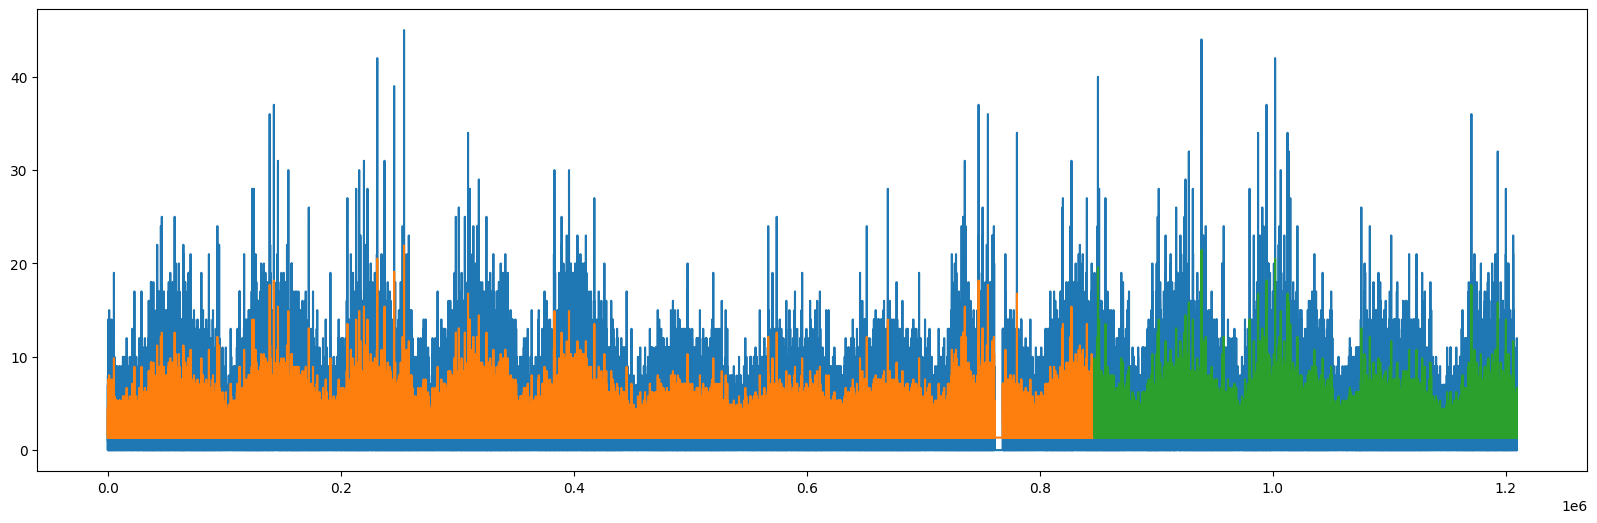

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,6))
plt.plot(min_max_scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

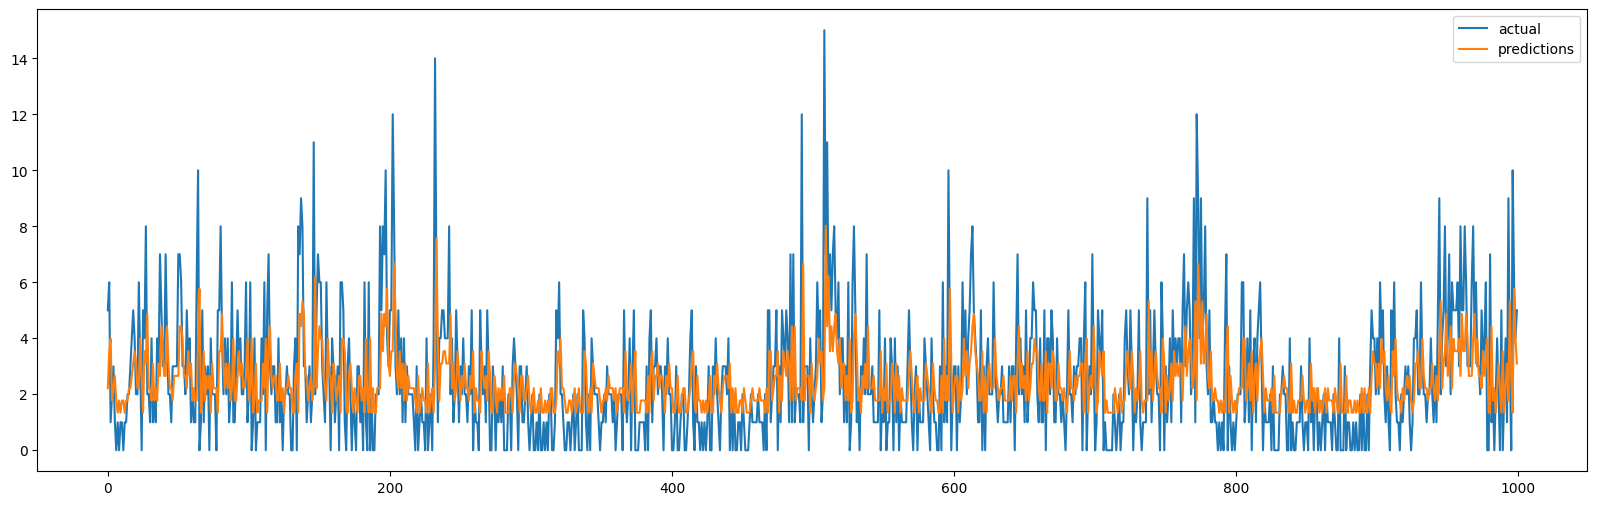

In [ ]:
## visualize results
plt.figure(figsize=(20,6))
plt.plot(min_max_scaler.inverse_transform(dataset)[1199000:1200000], label = 'actual')
plt.plot(testPredictPlot[1199000:1200000], label = 'predictions')
plt.legend()

>reference: https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


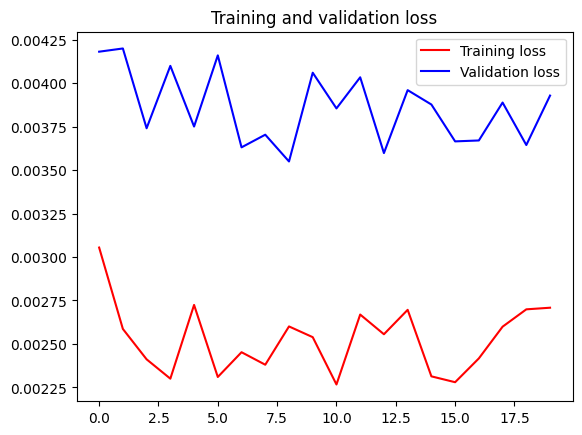

<Figure size 640x480 with 0 Axes>

In [ ]:
print(history.history.keys())
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()